# Function Approximation: DQN

A problem with the techniques we have seen so far is that they can be applied to learning problems with observation and action spaces that can be discretized. The value-function can be stored in a table or a dict.

If we have continuous data, it is impossible to have a data structure to store a value for each state or state-action pair. In this case we try to approximate the value-function.

## The Environment: Cart Pole

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

An instance of the observation space is a tuple with
- Cart Position in [-4.8, 4.8]
- Cart Velocity in [-Inf, Inf]
- Pole Angle in [-0.418 rad (-24 deg), 0.418 rad (24 deg)]
- Pole Angular Velocity in [-Inf, Inf]

The action space has discrete actions
- 0: Move pole to the left.
- 1: Move pole to the right.

The reward is 1 every step, including termination step. The episode ends when it reaches 200 timesteps.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
!pip install gymnasium
import gymnasium as gym
import matplotlib.pyplot as plt

print(f"OpenAI Gym version: {gym.__version__}")
print(f'PyTorch version {torch.__version__}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.4 MB/s eta 0:00:00
OpenAI Gym version: 0.29.1
PyTorch version 2.1.0+cu118


### Helpers

In [ ]:
# Video management imports
import cv2

# Helper functions to save videos and images
def save_video(img_array, path='./video/test.mp4'):
  height, width, layers = img_array[0].shape
  size = (width, height)
  out = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*'AVC1'), 15, size)
  for i in range(len(img_array)):
    bgr_img = cv2.cvtColor(img_array[i], cv2.COLOR_RGB2BGR)
    out.write(bgr_img)
  out.release()
  print('Video saved.')

def save_images(img_array, path='./images'):
  for i, image in enumerate(img_array):
    bgr_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path + '/img_' + str(i) + '.jpg', bgr_img)

## Trying the Environment

Observation Type: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32), Action Type: Discrete(2)
Observation: [-4.6835299e+00  2.5655003e+38 -1.8993163e-01 -2.1542527e+38], Action: 0


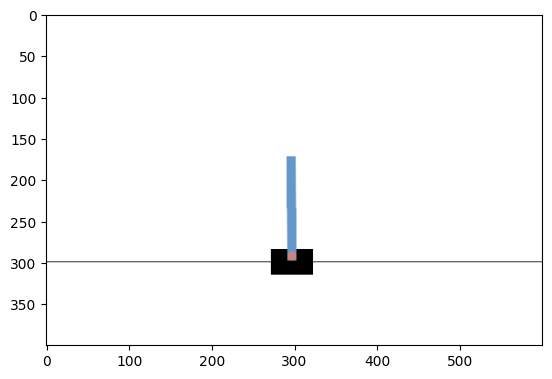

In [ ]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')
print('Observation Type: {}, Action Type: {}'.format(env.observation_space, env.action_space))
print('Observation: {}, Action: {}'.format(env.observation_space.sample(), env.action_space.sample()))

env.reset()
image = env.render()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)

## DQN Agent

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size, gamma, epsilon, epsilon_decay, epsilon_min):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = deque(maxlen=2000)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Define the Q-network
        self.q_network = QNetwork(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action_values = self.q_network(state)
        return torch.argmax(action_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        q_values = self.q_network(states).gather(1, actions)
        next_q_values = self.q_network(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = F.mse_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

Remember the update rule for Q-Learning:

$$ Q(S_t, A_t, \mathbf{\text{w}}_t) = Q(S_t, A_t, \mathbf{\text{w}}_t) + \alpha(R_{t+1} + \gamma \max_{a} Q(S_{t+1}, a, \mathbf{\text{w}}_t^{-}) - Q(S_t, A_t, \mathbf{\text{w}}_t)) $$

We are approximating $Q(S_t, A_t, \mathbf{\text{w}}_t)$, so this is our estimate. For updating the DNN, we need the observations, that we obtain from experience, and the true values or labels, corresponding to these observations. To obtain these labels we need the unbiased estimate of the state value function, that we obtain from experience too:

$$ U_t = R_{t+1} + \gamma \max_{a} Q(S_{t+1}, a, \mathbf{\text{w}}_t^{-}) $$

Also called the TD target. We already have $R_{t+1}$ and $S_{t+1}$ from experience, but we need the Q-value from the best action from this state. This Q-value is computed from the 'target' network, which is the one we update once every $t$ steps.

The TD target gives us the approximation for $Q(S_t, A_t, \mathbf{\text{w}}_t)$, i.e., only for the action $A_t$ of the sample of experience we are considering. The rest of the Q-values for state $S_t$ are the same, and are obtained from the 'online' network.

By updating the Q-values from the 'online' network for action $A_t$ with the TD target computed from the 'target' network, we obtain the true values that will serve as labels for updating the 'online' network.

## Training

In [ ]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01

agent = DQNAgent(state_size, action_size, batch_size, gamma, epsilon, epsilon_decay, epsilon_min)

EPISODES = 10_000
MAX_TIMESTEPS = 500
score_history = []
average_score = 0.0

for episode in range(EPISODES):
    state, _ = env.reset()
    score = 0

    for t in range(MAX_TIMESTEPS):
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.remember(state, action, reward, next_state, done)
        state = next_state
        score += reward

        if done:
            break

    score_history.append(score)
    if (episode+1) % 100 == 0:
        average_score = sum(score_history[-100:]) / 100
        print(f"Episode {episode + 1}/{EPISODES} | Average Reward (Last 100 episodes): {average_score:.2f}")

    agent.replay()

    if average_score >= 195:
        print(f"Environment solved in {episode + 1} episodes!")
        break

env.close()

<ipython-input-6-eaf24d6dbfb4>:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  states = torch.FloatTensor(states).to(self.device)


Episode 100/10000 | Average Reward (Last 100 episodes): 21.52
Episode 200/10000 | Average Reward (Last 100 episodes): 22.76
Episode 300/10000 | Average Reward (Last 100 episodes): 27.26
Episode 400/10000 | Average Reward (Last 100 episodes): 51.43
Episode 500/10000 | Average Reward (Last 100 episodes): 53.55
Episode 600/10000 | Average Reward (Last 100 episodes): 38.22
Episode 700/10000 | Average Reward (Last 100 episodes): 33.75
Episode 800/10000 | Average Reward (Last 100 episodes): 38.68
Episode 900/10000 | Average Reward (Last 100 episodes): 35.01
Episode 1000/10000 | Average Reward (Last 100 episodes): 36.19
Episode 1100/10000 | Average Reward (Last 100 episodes): 43.17
Episode 1200/10000 | Average Reward (Last 100 episodes): 53.49
Episode 1300/10000 | Average Reward (Last 100 episodes): 51.59
Episode 1400/10000 | Average Reward (Last 100 episodes): 57.22
Episode 1500/10000 | Average Reward (Last 100 episodes): 54.48
Episode 1600/10000 | Average Reward (Last 100 episodes): 61.18
E

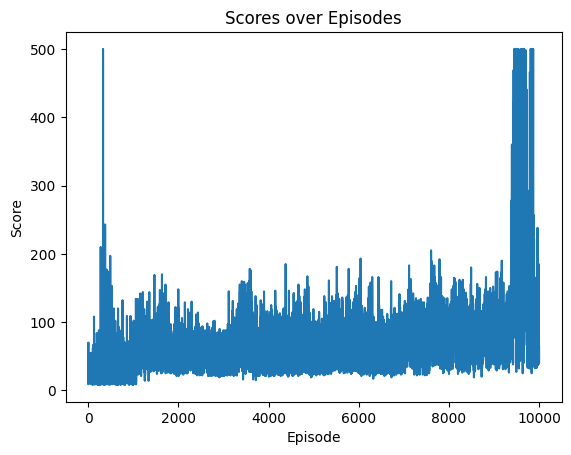

In [ ]:
episodes = list(range(1, len(score_history)+1))
plt.plot(episodes, score_history)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Scores over Episodes')
plt.show()

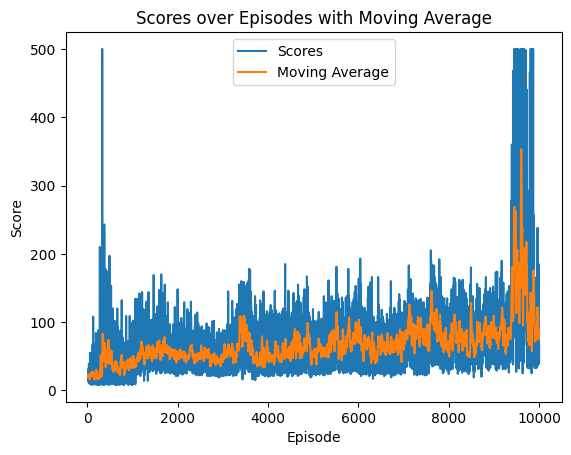

In [ ]:
import numpy as np

# Calculate the moving average
window_size = 20
moving_average = np.convolve(score_history, np.ones(window_size), 'valid') / window_size

# Generate x-axis values
episodes = list(range(window_size, len(score_history)+1))

# Plot the scores and moving average
plt.plot(episodes, score_history[window_size-1:], label='Scores')
plt.plot(episodes, moving_average, label='Moving Average')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Scores over Episodes with Moving Average')
plt.legend()
plt.show()

## Testing

In [ ]:
EPISODES = 10

env = gym.make("CartPole-v1", render_mode='rgb_array')

scores = []

for episode in range(EPISODES):
    state, _ = env.reset()
    score = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        state = next_state
        score += reward

        if done:
            break

    scores.append(score)
    print(f"Episode {episode + 1}/{EPISODES} - Score: {score}")

env.close()

average_score = sum(scores) / EPISODES
print(f"\nAverage Score (Over {EPISODES} episodes): {average_score:.2f}")

Episode 1/10 - Score: 111.0
Episode 2/10 - Score: 107.0
Episode 3/10 - Score: 95.0
Episode 4/10 - Score: 99.0
Episode 5/10 - Score: 115.0
Episode 6/10 - Score: 100.0
Episode 7/10 - Score: 118.0
Episode 8/10 - Score: 102.0
Episode 9/10 - Score: 112.0
Episode 10/10 - Score: 130.0

Average Score (Over 10 episodes): 108.90


In [ ]:
observation, _ = env.reset()
done = False
images = []
while not done:
    action = agent.select_action(observation)
    observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    image = env.render()
    images.append(image)

    if len(images) > 100:
        done = True

save_video(images, path='video/DQN.mp4')

Video saved.


In [ ]:
from IPython.display import Video
Video('./video/DQN.mp4', embed=True)

# Two network optimization

In previous code we were using to select the actions the same network that we were training. Using two networks can help improve the stability:

1. One network is used as policy to select the next action
2. The second network is being trained.

In [ ]:
class DQNAgent2:
    def __init__(self, state_size, action_size, batch_size, gamma, epsilon, epsilon_decay, epsilon_min, num_sync):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = deque(maxlen=2000)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.num_sync = num_sync
        self.sync_counter = 0

        # Define the Q-network and target network
        self.q_network = QNetwork(state_size, action_size).to(self.device)
        self.target_network = QNetwork(state_size, action_size).to(self.device)

        # copy the state of the two networks
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action_values = self.q_network(state)
        return torch.argmax(action_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        q_values = self.q_network(states).gather(1, actions)
        next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = F.mse_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Synchronize the target network with the Q-network every num_sync steps
        self.sync_counter += 1
        if self.sync_counter % self.num_sync == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

In this modified version of the DQNAgent class, we added the target_network attribute, which is initially synchronized with the q_network in the __init__ method using load_state_dict. The target_network is then kept fixed during the replay process.

After each optimization step, we increment the sync_counter and check if it's time to synchronize the target_network with the q_network. If the sync_counter reaches num_sync, we update the target_network using load_state_dict to copy the weights from the q_network.

By using a separate target_network, we can stabilize the learning process and avoid the problem of overestimating action values during training.

## Training

In [ ]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01

agent = DQNAgent2(state_size, action_size, batch_size, gamma, epsilon, epsilon_decay, epsilon_min, 100)

EPISODES = 10_000
MAX_TIMESTEPS = 500
score_history = []

for episode in range(EPISODES):
    state, _ = env.reset()
    score = 0

    for t in range(MAX_TIMESTEPS):
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.remember(state, action, reward, next_state, done)
        state = next_state
        score += reward

        if done:
            break

    score_history.append(score)
    if episode % 100 == 0:
        average_score = sum(score_history[-100:]) / 100
        print(f"Episode {episode + 1}/{EPISODES} - Score: {score} - Average Score (Last 100 episodes): {average_score:.2f}")

    agent.replay()

    if average_score >= 195:
        print(f"Environment solved in {episode + 1} episodes!")
        break

env.close()

Episode 1/10000 - Score: 15.0 - Average Score (Last 100 episodes): 0.15
Episode 101/10000 - Score: 23.0 - Average Score (Last 100 episodes): 21.20
Episode 201/10000 - Score: 12.0 - Average Score (Last 100 episodes): 13.05
Episode 301/10000 - Score: 9.0 - Average Score (Last 100 episodes): 11.54
Episode 401/10000 - Score: 10.0 - Average Score (Last 100 episodes): 10.67
Episode 501/10000 - Score: 8.0 - Average Score (Last 100 episodes): 10.33
Episode 601/10000 - Score: 8.0 - Average Score (Last 100 episodes): 11.93
Episode 701/10000 - Score: 10.0 - Average Score (Last 100 episodes): 11.74
Episode 801/10000 - Score: 9.0 - Average Score (Last 100 episodes): 9.36
Episode 901/10000 - Score: 10.0 - Average Score (Last 100 episodes): 9.32
Episode 1001/10000 - Score: 10.0 - Average Score (Last 100 episodes): 9.26
Episode 1101/10000 - Score: 10.0 - Average Score (Last 100 episodes): 9.46
Episode 1201/10000 - Score: 10.0 - Average Score (Last 100 episodes): 9.41
Episode 1301/10000 - Score: 10.0 -

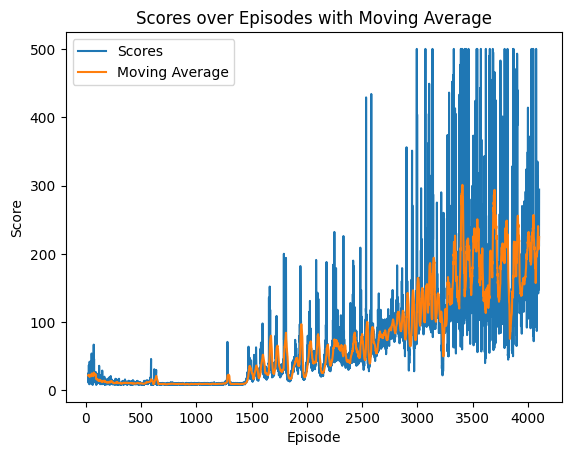

In [ ]:
import numpy as np

# Calculate the moving average
window_size = 20
moving_average = np.convolve(score_history, np.ones(window_size), 'valid') / window_size

# Generate x-axis values
episodes = list(range(window_size, len(score_history)+1))

# Plot the scores and moving average
plt.plot(episodes, score_history[window_size-1:], label='Scores')
plt.plot(episodes, moving_average, label='Moving Average')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Scores over Episodes with Moving Average')
plt.legend()
plt.show()

## Testing

In [ ]:
EPISODES = 10

env = gym.make("CartPole-v1", render_mode='rgb_array')

scores = []

for episode in range(EPISODES):
    state, _ = env.reset()
    score = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        state = next_state
        score += reward

        if done:
            break

    scores.append(score)
    print(f"Episode {episode + 1}/{EPISODES} - Score: {score}")

env.close()

average_score = sum(scores) / EPISODES
print(f"\nAverage Score (Over {EPISODES} episodes): {average_score:.2f}")

Episode 1/10 - Score: 251.0
Episode 2/10 - Score: 239.0
Episode 3/10 - Score: 340.0
Episode 4/10 - Score: 460.0
Episode 5/10 - Score: 228.0
Episode 6/10 - Score: 263.0
Episode 7/10 - Score: 188.0
Episode 8/10 - Score: 91.0
Episode 9/10 - Score: 195.0
Episode 10/10 - Score: 264.0

Average Score (Over 10 episodes): 251.90


In [ ]:
EPISODES = 10

env = gym.make("CartPole-v1", render_mode='rgb_array')

scores = []

for episode in range(EPISODES):
    state, _ = env.reset()
    score = 0

    while True:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        state = next_state
        score += reward

        if done:
            break

    scores.append(score)
    print(f"Episode {episode + 1}/{EPISODES} - Score: {score}")

env.close()

average_score = sum(scores) / EPISODES
print(f"\nAverage Score (Over {EPISODES} episodes): {average_score:.2f}")

Episode 1/10 - Score: 282.0
Episode 2/10 - Score: 225.0
Episode 3/10 - Score: 187.0
Episode 4/10 - Score: 192.0
Episode 5/10 - Score: 228.0
Episode 6/10 - Score: 192.0
Episode 7/10 - Score: 74.0
Episode 8/10 - Score: 262.0
Episode 9/10 - Score: 271.0
Episode 10/10 - Score: 260.0

Average Score (Over 10 episodes): 217.30


In [ ]:
observation, _ = env.reset()
done = False
images = []
while not done:
    action = agent.select_action(observation)
    observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    image = env.render()
    images.append(image)

    if len(images) > 100:
        done = True

save_video(images, path='video/DQN2.mp4')

Video saved.
